In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def own_kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def own_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def own_loss(y_true, y_pred):
    return 1.0*own_kullback_leibler_divergence(y_true, y_pred)+own_mean_squared_error(y_true, y_pred)

# utility function for showing images
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()


input_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

(x_all, y_all), (x_all_test, y_all_test) = mnist.load_data()

x_9_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 9):
        x_9_list.append(x_all[i])
x_9=np.asarray(x_9_list[:5000])
x_9_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 9):
        x_9_list_test.append(x_all_test[i])
x_9_test=np.asarray(x_9_list_test[:500])

x_train = x_9
x_test = x_9_test

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train.shape)

### pretrain

train1_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col

train1_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(train1_conv1)

train1_autoencoder = Model(input_img, train1_decoded)
train1_autoencoder.compile(optimizer='adadelta', loss=own_loss)

train1_autoencoder.fit(x_train_noisy, x_train, epochs=1, batch_size=20,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(5000, 28, 28, 1)
Train on 5000 samples, validate on 500 samples
Epoch 1/1
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0616 - val_loss: 0.0081


In [2]:
train1_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         401       
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [3]:
#decoded_imgs = train1_autoencoder.predict(x_train)
## print "input (upper row)\ndecoded (bottom row)"
#show_imgs(x_train, decoded_imgs)

input_creator_train2 = Model(input_img, train1_conv1)
for i in range(2):
    input_creator_train2.layers[i].set_weights(train1_autoencoder.layers[i].get_weights())

input_train2 = input_creator_train2.predict(x_train_noisy)

input_train2.shape

(5000, 28, 28, 16)

In [4]:
input_img_train2 = Input(shape=(28, 28,16))

train2_pool1 = MaxPooling2D(pool_size=(2, 2))(input_img_train2)
train2_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(train2_pool1) #nb_filter, nb_row, nb_col

#---

train2_pool2 = UpSampling2D(size=(2, 2))(train2_conv1)
train2_decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(train2_pool2)

train2_autoencoder = Model(input_img_train2, train2_decoded)
train2_autoencoder.compile(optimizer='adadelta', loss=own_loss)

train2_autoencoder.fit(input_train2, input_train2, epochs=1, batch_size=20, verbose=1)

Epoch 1/1
5000/5000 [==============================] - 10s 2ms/step - loss: -1.6795


In [5]:
train2_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        1168      
Total params: 2,328
Trainable params: 2,328
Non-trainable params: 0
_________________________________________________________________


In [6]:
#decoded_imgs = train1_autoencoder.predict(x_train)
## print "input (upper row)\ndecoded (bottom row)"
#show_imgs(x_train, decoded_imgs)

input_creator_train3 = Model(input_img_train2, train2_conv1)
for i in range(3):
    input_creator_train3.layers[i].set_weights(train2_autoencoder.layers[i].get_weights())

input_train3 = input_creator_train3.predict(input_creator_train2.predict(x_train_noisy))

input_train3.shape

(5000, 14, 14, 8)

In [7]:
input_img_train3 = Input(shape=(14, 14,8))

train3_pool1 = MaxPooling2D(pool_size=(2, 2))(input_img_train3)
train3_conv1 = Conv2D(4, (3, 3), activation='relu', padding='same')(train3_pool1) #nb_filter, nb_row, nb_col

#---

train3_pool2 = UpSampling2D(size=(2, 2))(train3_conv1)
train3_decoded = Conv2D(8, (3, 3), activation='relu', padding='same')(train3_pool2)

train3_autoencoder = Model(input_img_train3, train3_decoded)
train3_autoencoder.compile(optimizer='adadelta', loss=own_loss)

train3_autoencoder.fit(input_train3, input_train3, epochs=1, batch_size=20, verbose=1)

Epoch 1/1
5000/5000 [==============================] - 2s 431us/step - loss: 0.0376


In [8]:
train3_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         296       
Total params: 588
Trainable params: 588
Non-trainable params: 0
_________________________________________________________________


In [9]:
### unroll

conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #nb_filter, nb_row, nb_col

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(pool2)

pool3 = UpSampling2D(size=(2, 2))(encoded)
conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool3)

pool4 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4)

decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(conv5)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss=own_loss)

print(train1_conv1.shape)

autoencoder.layers[0].set_weights(train1_autoencoder.layers[0].get_weights())
autoencoder.layers[1].set_weights(train1_autoencoder.layers[1].get_weights())

autoencoder.layers[10].set_weights(train1_autoencoder.layers[2].get_weights())

(?, 28, 28, 16)


In [10]:

autoencoder.layers[2].set_weights(train2_autoencoder.layers[1].get_weights())
autoencoder.layers[3].set_weights(train2_autoencoder.layers[2].get_weights())

autoencoder.layers[8].set_weights(train2_autoencoder.layers[3].get_weights())
autoencoder.layers[9].set_weights(train2_autoencoder.layers[4].get_weights())

autoencoder.layers[4].set_weights(train3_autoencoder.layers[1].get_weights())
autoencoder.layers[5].set_weights(train3_autoencoder.layers[2].get_weights())
autoencoder.layers[6].set_weights(train3_autoencoder.layers[3].get_weights())
autoencoder.layers[7].set_weights(train3_autoencoder.layers[4].get_weights())

In [11]:
print("shape of decoded", K.int_shape(encoded))
print("shape of decoded", K.int_shape(decoded))

### fine tune

autoencoder.fit(x_train_noisy, x_train, epochs=1, batch_size=20,
            shuffle=True, validation_data=(x_test, x_test), verbose=1)

shape of decoded (None, 7, 7, 4)
shape of decoded (None, 28, 28, 1)
Train on 5000 samples, validate on 500 samples
Epoch 1/1
5000/5000 [==============================] - 15s 3ms/step - loss: 0.5156 - val_loss: 0.0804


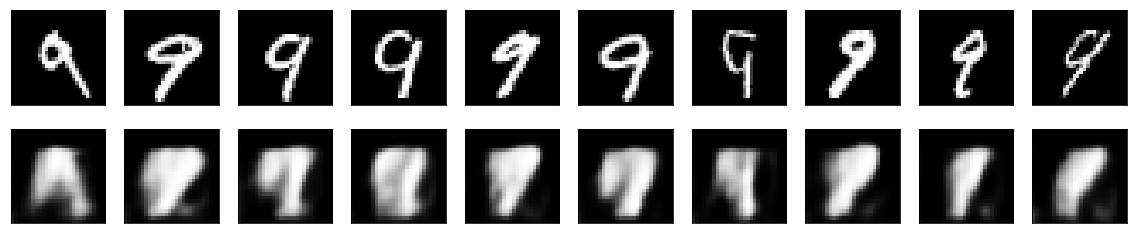

In [12]:
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
decoded_imgs = autoencoder.predict(x_test_noisy)
show_imgs(x_test, decoded_imgs)

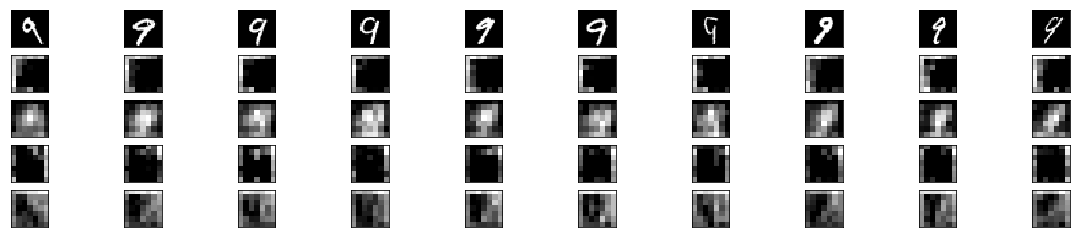

In [13]:
enbig1 = UpSampling2D(size=(2, 2))(encoded)
enbig2 = UpSampling2D(size=(2, 2))(enbig1)

autoencoder_show_hidden = Model(input_img, enbig2)
encoded_imgs = autoencoder_show_hidden.predict(x_test_noisy)

def show_hidden(x_test, encoded_imgs, n=10):
    
    en0=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en1=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en2=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en3=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))

    for i in range(encoded_imgs.shape[0]):
        for j in range(encoded_imgs.shape[1]):
            for k in range(encoded_imgs.shape[2]):
                en0[i][j][k]=encoded_imgs[i][j][k][0]
                en1[i][j][k]=encoded_imgs[i][j][k][1]
                en2[i][j][k]=encoded_imgs[i][j][k][2]
                en3[i][j][k]=encoded_imgs[i][j][k][3]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(5, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(5, n, i+ 1 +n)
            plt.imshow(en0[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +2*n)
            plt.imshow(en1[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +3*n)
            plt.imshow(en2[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +4*n)
            plt.imshow(en3[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

show_hidden(x_test, encoded_imgs)

In [14]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 4)         0         
__________